In [1]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
from custom_indicators import CustomIndocators as ci
import pandas as pd
import ta
import ccxt
import json

In [2]:
# pairList = pairJson['hitbtc2018']
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='../database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 37517 candles for ETHUSDT


In [3]:
# -- Indicator variable --
trixWindow = 9
trixSignal = 21
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
trix = ci.trix(close=df['close'],trixLength=trixWindow, trixSignal=trixSignal)
df['TRIX_HISTO'] = trix.trix_histo()

df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow)

print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877,NaN,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,NaN,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,NaN,NaN
...,...,...,...,...,...,...,...
2021-12-02 10:00:00,4578.37,4592.50,4538.02,4555.91,15415.97430,-0.045537,0.724227
2021-12-02 11:00:00,4555.92,4563.18,4495.37,4531.25,22268.65310,-0.024907,0.504580
2021-12-02 12:00:00,4531.25,4549.28,4499.93,4536.53,17620.89440,-0.007767,0.569605


In [4]:
# -- Intern parameter --
# dfTest = df['2017-10-24':'2018-01-31']
dfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
stochOverBought = 0.8
stochOverSold = 0.2
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if (
        row['TRIX_HISTO'] >= 0
        and row['STOCH_RSI'] < stochOverBought
    ):
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if (
        row['TRIX_HISTO'] < 0
        and row['STOCH_RSI'] > stochOverSold
    ):
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0 and buyReady == True:
        # -- You can define here at what price you buy --
        buyPrice = row['close']

        # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
        if StopLossActivation:
            stopLoss = buyPrice - SlPct * buyPrice
        if takeProfitActivation:
            takeProfit = buyPrice + TpPct * buyPrice
        if timeLimitActivation:
            currentTimeOpen = 1

        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Take Profit --
    elif row['high'] > takeProfit and coin > 0:
        sellPrice = takeProfit
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Take Profit',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Stop Loss --
    elif row['low'] < stopLoss and coin > 0:
        sellPrice = stopLoss
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        currentTimeOpen = 0

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Stop Loss", sellPrice, '$ the', index)
        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Stop Loss',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        buyReady = True
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            # buyReady = True
            wallet = usd

            # -- You can uncomment the line below if you want to see logs --
            if showLog:
                print("Sell COIN at", sellPrice, '$ the', index)

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0

    elif currentTimeOpen > timeLimit and coin > 0:
        sellPrice = row['close']
        usd = coin * sellPrice
        fee = takerFee * usd
        usd = usd - fee
        coin = 0
        if waitNextSignal:
            buyReady = False
        wallet = usd

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at", sellPrice, '$ the', index)

        # -- Add the trade to DfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Time Market Order',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    previousRow = row

print("Final wallet", wallet)


Final wallet 735307.8726416291


In [6]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : ETH/USDT | Timeframe : 1h
Period : [2017-08-17 04:00:00] -> [2021-12-02 14:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 735307.87 $
Performance vs US Dollar : 73482.29 %
Buy and Hold Performence : 1421.6 %
Performance vs Buy and Hold : 4735.84 %
Best trade : +40.44 %, the 2021-01-04 12:00:00
Worst trade : -17.52 %, the 2018-08-14 02:00:00
Worst drawDown : - 31.88 %
Total fees :  239350.76 $

----- Trades Informations -----
Total trades on period : 960
Number of positive trades : 483
Number of negative trades :  477
Trades win rate ratio : 50.31 %
Average trades performance : 0.86 %
Average positive trades : 3.75 %
Average negative trades : -2.06 %

----- Time Informations -----
Average time duration for a trade : 18.53 periods
Maximum time duration for a trade : 70 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 20.53 periods
Maximum time duration between two trades : 66 periods
Minimu

----- 2017 Performances: 333.66% -----


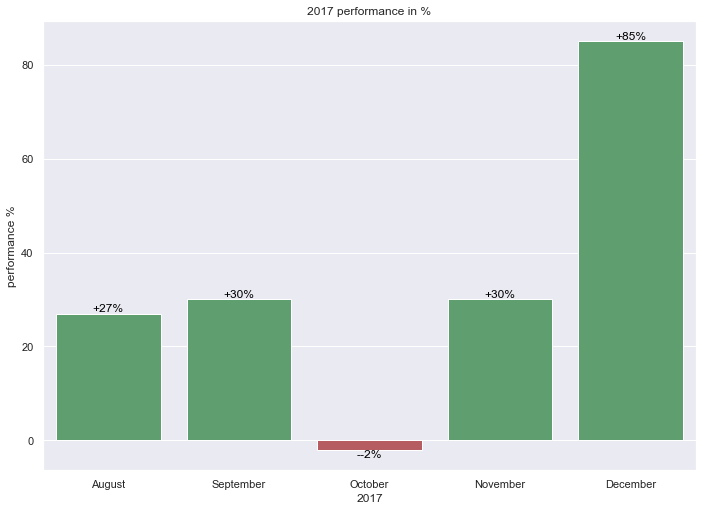

----- 2018 Performances: 217.28% -----


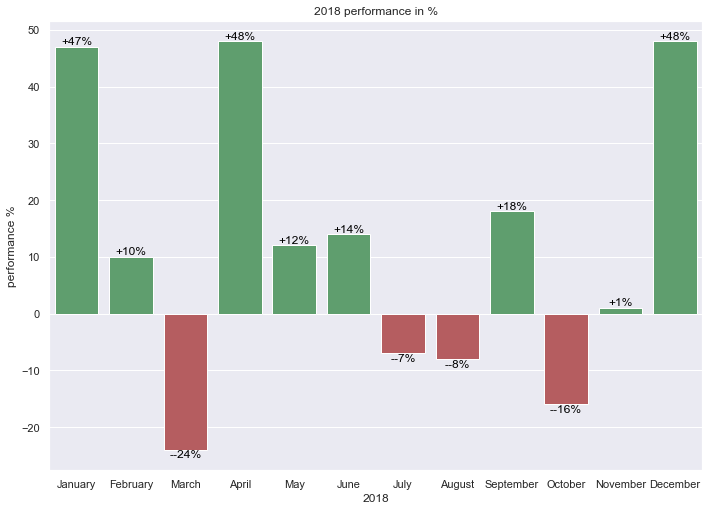

----- 2019 Performances: 150.22% -----


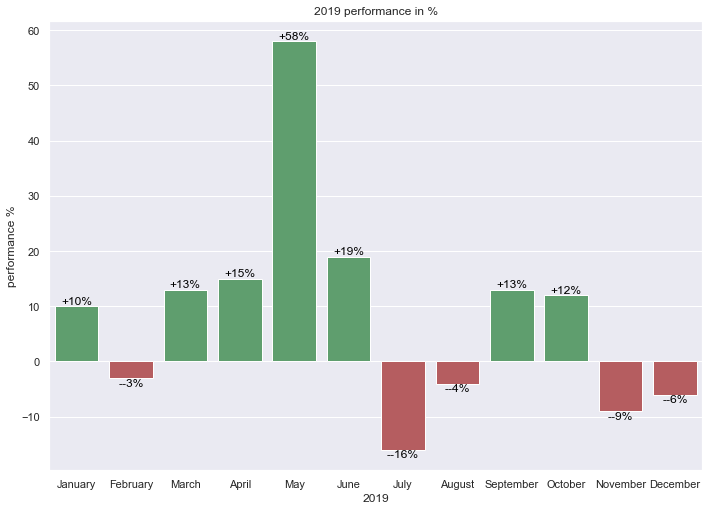

----- 2020 Performances: 437.03% -----


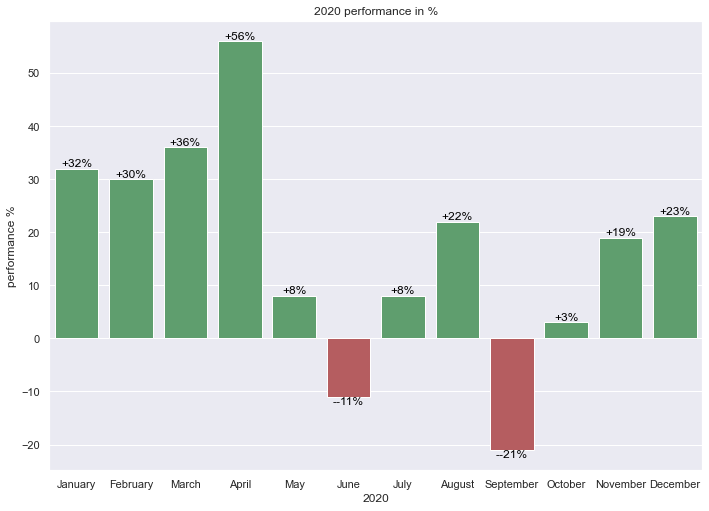

----- 2021 Performances: 264.94% -----


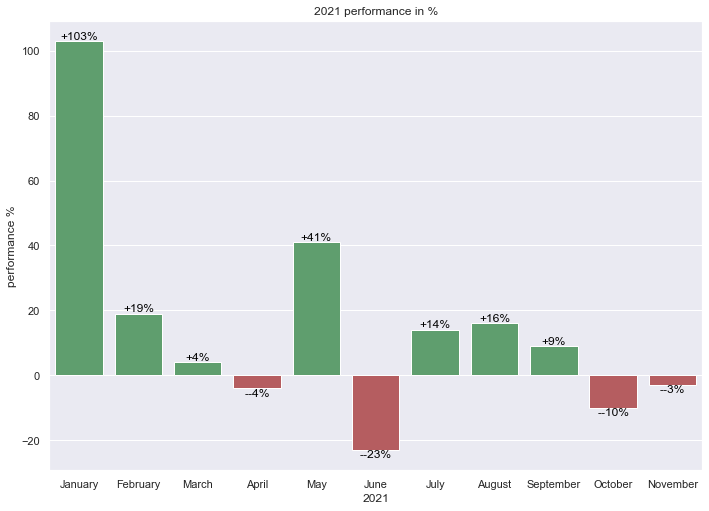

In [7]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)

C:\Users\tl170571\AppData\Local\Temp/ipykernel_15696/3056460112.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  BTobject.plot_wallet_evolution(dfTrades=newDf['2021'])



----- Plot -----


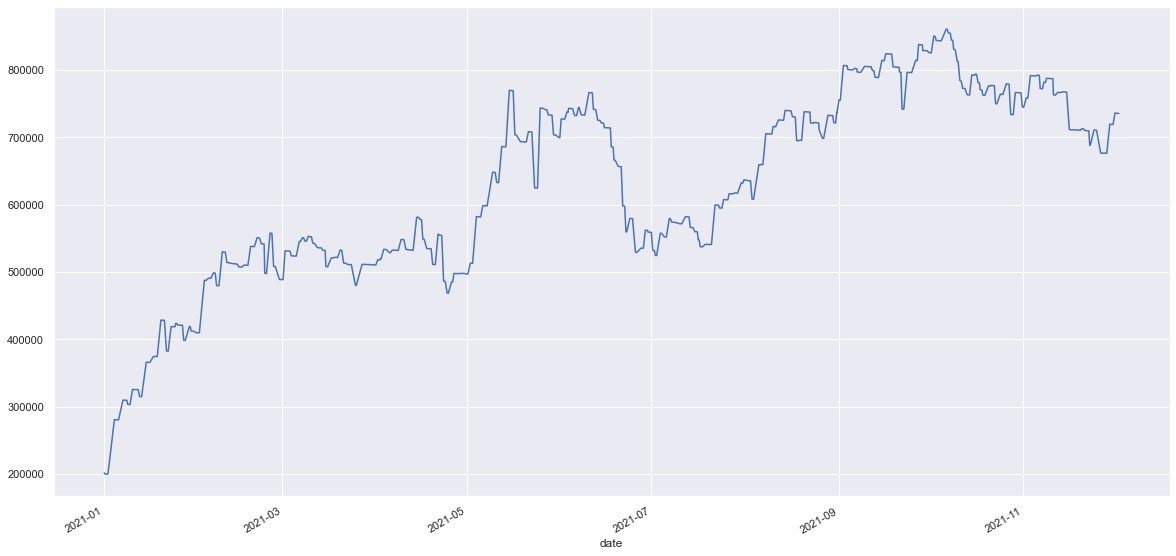

In [8]:
BTobject.plot_wallet_evolution(dfTrades=newDf['2021'])